Especialização em Ciência dos Dados – Redes Neurais Artificiais (Aprendizado Profundo/Deep Learning)

1º Desafio em RNA/Deep Learning

Aluna: Cristiane Gea

In [1]:
# ==========================
# IMPORTAÇÕES E LEITURA BASE
# ==========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# Carregar e limpar base
df = pd.read_excel("funcao.xlsx")
df_xy = df[['x','y']].dropna().copy()
X = df_xy[['x']].values.astype(float)
y = df_xy['y'].values.astype(float)

In [3]:
# Extrair curva alvo (linha vermelha = ymean em função de xgrd)
if 'xgrd' in df.columns and 'ymean' in df.columns:
    grd = df[['xgrd','ymean']].dropna().drop_duplicates().sort_values('xgrd')
    xgrd = grd['xgrd'].values.reshape(-1,1)
    ymean = grd['ymean'].values
else:
    # fallback se não houver ymean explícito
    xgrd = np.linspace(X.min(), X.max(), 201).reshape(-1,1)
    from sklearn.gaussian_process import GaussianProcessRegressor
    gp = GaussianProcessRegressor().fit(X, y)
    ymean = gp.predict(xgrd)

In [4]:
# Split treino/validação (20% val)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalização (fit só no treino)
sc_X = StandardScaler().fit(X_train)
sc_y = StandardScaler().fit(y_train.reshape(-1,1))
Xs_train = sc_X.transform(X_train)
Xs_val = sc_X.transform(X_val)
xgrd_s = sc_X.transform(xgrd)
ys_train = sc_y.transform(y_train.reshape(-1,1)).ravel()
ys_val = sc_y.transform(y_val.reshape(-1,1)).ravel()

In [5]:
# -------------------------
# Parâmetros do experimento (itens 1,2,3)
# -------------------------
hidden_candidates = [1, 2, 4, 8, 16, 32]    # experimente essa grade (inclui 1)
activation = 'relu'                         # teste aqui relu/tanh/logistic separadamente
epochs = 1000
n_repeats = 5

In [6]:
# -------------------------
# Função que avalia os tamanhos e retorna métricas
# -------------------------
def evaluate_hidden_sizes(hidden_candidates, activation='relu', epochs=1000, n_repeats=5):
    results = []
    for hs in hidden_candidates:
        rmses = []
        preds_grid = []
        for rep in range(n_repeats):
            seed = 100 + rep
            model = MLPRegressor(hidden_layer_sizes=(hs,),
                                 activation=activation,
                                 solver='adam',
                                 max_iter=epochs,
                                 random_state=seed,
                                 learning_rate_init=0.001,
                                 tol=1e-6)
            model.fit(Xs_train, ys_train)

            # RMSE em validação
            pred_val_s = model.predict(Xs_val)
            pred_val = sc_y.inverse_transform(pred_val_s.reshape(-1,1)).ravel()
            rmse_val = np.sqrt(mean_squared_error(y_val, pred_val))
            rmses.append(rmse_val)

            # Predição na grade (para comparação com ymean)
            pred_grid_s = model.predict(xgrd_s)
            pred_grid = sc_y.inverse_transform(pred_grid_s.reshape(-1,1)).ravel()
            preds_grid.append(pred_grid)

        results.append({
            'hidden': hs,
            'rmse_mean': np.mean(rmses),
            'rmse_std': np.std(rmses),
            'preds_grid': np.array(preds_grid)  # shape (n_repeats, ng)
        })
    return results

# rodar a avaliação
results = evaluate_hidden_sizes(hidden_candidates, activation=activation, epochs=epochs, n_repeats=n_repeats)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perce

In [7]:
# -------------------------
# Escolha automática da topologia mínima
# -------------------------
def choose_minimal_by_tolerance(results, tol=0.05):
    # tol = 0.05 -> aceitar topologias até 5% pior do que o melhor RMSE encontrado
    means = np.array([r['rmse_mean'] for r in results])
    best = means.min()
    acceptable = best * (1 + tol)
    # encontrar menor hidden cujo rmse_mean <= acceptable
    for r in sorted(results, key=lambda x: x['hidden']):
        if r['rmse_mean'] <= acceptable:
            return r, best, acceptable
    # se nenhuma satisfaz, retorna a melhor (mais complexa possivelmente)
    best_idx = np.argmin(means)
    return results[best_idx], best, acceptable

def choose_minimal_by_elbow(results, improvement_tol=0.01):
    # improvement_tol = 0.01 -> quando a melhoria absoluta do RMSE é < 0.01, paramos
    sorted_res = sorted(results, key=lambda x: x['hidden'])
    means = np.array([r['rmse_mean'] for r in sorted_res]) # Convert to NumPy array
    prev = means[0]
    for i in range(1, len(means)):
        improvement = prev - means[i]
        if improvement < improvement_tol:
            # i é o primeiro com melhoria pequena -> escolha o tamanho anterior (mais simples)
            return sorted_res[max(0, i-1)], means.min(), improvement
        prev = means[i]
    # se nenhuma quebra o critério, retornar melhor
    best_idx = np.argmin(means)
    return sorted_res[best_idx], means.min(), 0.0

# aplicar critérios
min_tol_cfg, best_rmse, acceptable = choose_minimal_by_tolerance(results, tol=0.05)
min_elbow_cfg, _, _ = choose_minimal_by_elbow(results, improvement_tol=0.01)

print("Melhor (menor RMSE absoluto):", min(results, key=lambda r: r['rmse_mean'])['hidden'])
print("Topologia mínima (critério tolerância 5%):", min_tol_cfg['hidden'])
print("Topologia mínima (critério elbow):", min_elbow_cfg['hidden'])

Melhor (menor RMSE absoluto): 32
Topologia mínima (critério tolerância 5%): 32
Topologia mínima (critério elbow): 32


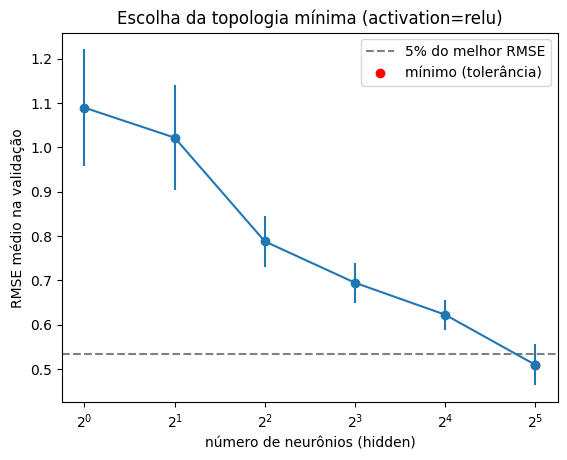

In [8]:
# -------------------------
# Plot RMSE médio vs hidden size e destacar escolha
# -------------------------
hs_list = [r['hidden'] for r in results]
rmse_means = [r['rmse_mean'] for r in results]
rmse_stds = [r['rmse_std'] for r in results]

plt.figure()
plt.errorbar(hs_list, rmse_means, yerr=rmse_stds, marker='o', linestyle='-')
plt.axhline(best_rmse * 1.05, color='gray', linestyle='--', label='5% do melhor RMSE')
plt.scatter([min_tol_cfg['hidden']], [min_tol_cfg['rmse_mean']], color='red', label='mínimo (tolerância)')
plt.xscale('log', base=2)  # opcional, porque hidden cresceu por fatores de 2
plt.xlabel('número de neurônios (hidden)')
plt.ylabel('RMSE médio na validação')
plt.legend()
plt.title(f'Escolha da topologia mínima (activation={activation})')
plt.show()

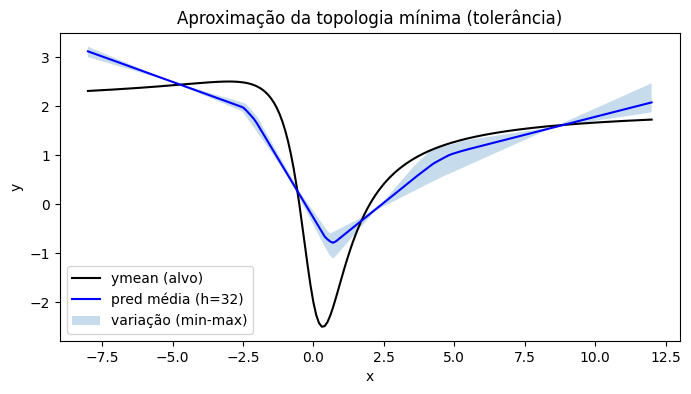

In [9]:
# -------------------------
# Visual: ymean vs predições médias da topologia mínima (tolerância)
# -------------------------
preds = min_tol_cfg['preds_grid']  # shape (n_repeats, ng)
mean_pred = preds.mean(axis=0)
min_pred = preds.min(axis=0)
max_pred = preds.max(axis=0)

plt.figure(figsize=(8,4))
plt.plot(xgrd.ravel(), ymean, label='ymean (alvo)', color='black')
plt.plot(xgrd.ravel(), mean_pred, label=f'pred média (h={min_tol_cfg["hidden"]})', color='blue')
plt.fill_between(xgrd.ravel(), min_pred, max_pred, alpha=0.25, label='variação (min-max)')
plt.legend(); plt.xlabel('x'); plt.ylabel('y'); plt.title('Aproximação da topologia mínima (tolerância)')
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perce

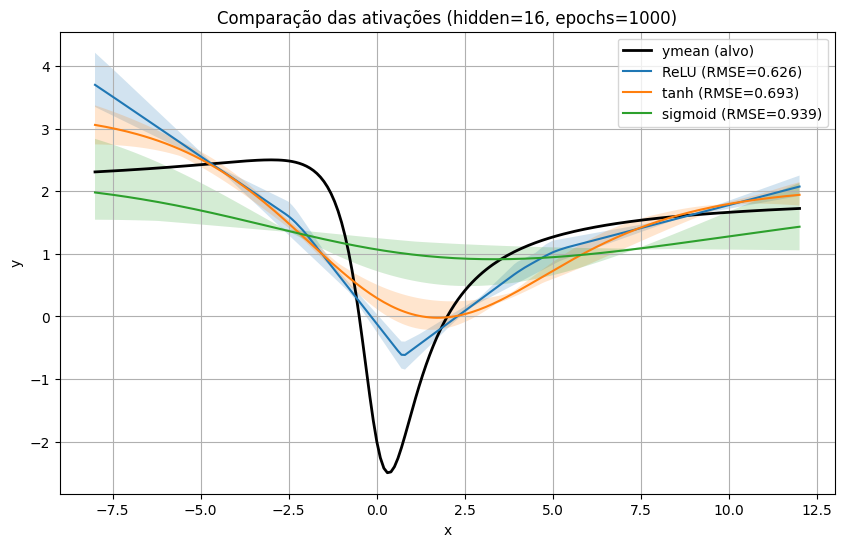

In [10]:
# ============================================================
# (2) TESTAR DIFERENTES FUNÇÕES DE ATIVAÇÃO NA CAMADA ESCONDIDA
# ============================================================
# As ativações escolhidas foram: ReLU, tangente hiperbólica e sigmoide.

# Ativações a comparar
activations = {
    'ReLU': 'relu',
    'tanh': 'tanh',
    'sigmoid': 'logistic'
}

# Parâmetros fixos
hidden_size = 16
epochs = 1000
n_repeats = 5

# Guardar resultados
results_act = []

for name, act in activations.items():
    preds_grid = []
    rmses = []
    for rep in range(n_repeats):
        seed = 42 + rep
        model = MLPRegressor(
            hidden_layer_sizes=(hidden_size,),
            activation=act,
            solver='adam',
            max_iter=epochs,
            random_state=seed,
            learning_rate_init=0.001,
            tol=1e-6
        )
        model.fit(Xs_train, ys_train)

        # Avaliar RMSE em validação
        pred_val_s = model.predict(Xs_val)
        pred_val = sc_y.inverse_transform(pred_val_s.reshape(-1,1)).ravel()
        rmse = np.sqrt(mean_squared_error(y_val, pred_val))
        rmses.append(rmse)

        # Predição na grade xgrd
        pred_grid_s = model.predict(xgrd_s)
        pred_grid = sc_y.inverse_transform(pred_grid_s.reshape(-1,1)).ravel()
        preds_grid.append(pred_grid)

    results_act.append({
        'activation': name,
        'rmse_mean': np.mean(rmses),
        'rmse_std': np.std(rmses),
        'preds': np.array(preds_grid)
    })

# Plotar comparações
plt.figure(figsize=(10,6))
plt.plot(xgrd.ravel(), ymean, color='black', label='ymean (alvo)', linewidth=2)
for r in results_act:
    mean_pred = r['preds'].mean(axis=0)
    min_pred = r['preds'].min(axis=0)
    max_pred = r['preds'].max(axis=0)
    plt.plot(xgrd.ravel(), mean_pred, label=f"{r['activation']} (RMSE={r['rmse_mean']:.3f})")
    plt.fill_between(xgrd.ravel(), min_pred, max_pred, alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Comparação das ativações (hidden={hidden_size}, epochs={epochs})')
plt.legend()
plt.grid(True)
plt.show()

Ativação: ReLU, Neurônios: 1, Epochs: 200
RMSE médio na validação: 1.8981 ± 0.7850


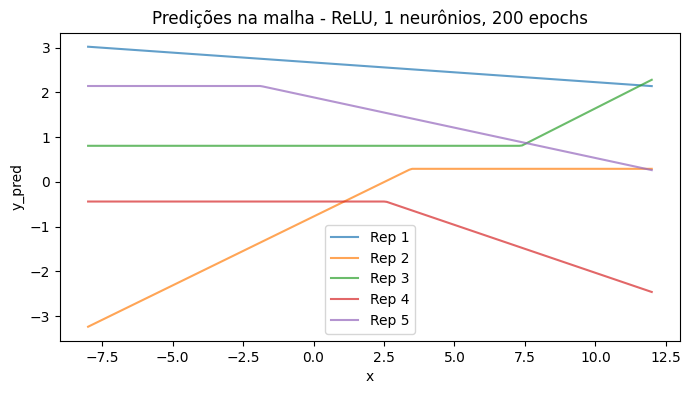

Ativação: ReLU, Neurônios: 1, Epochs: 1000
RMSE médio na validação: 1.2635 ± 0.2583


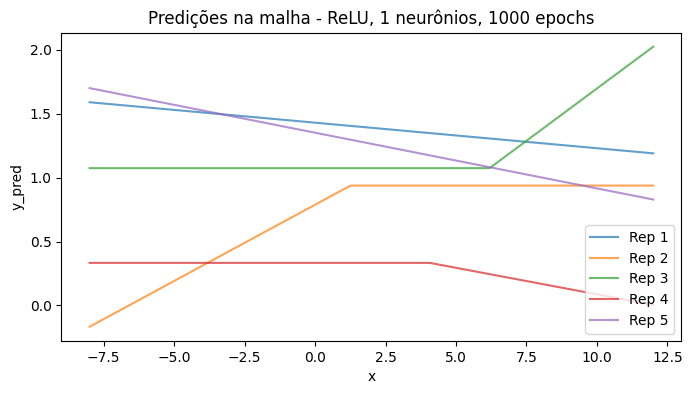

Ativação: ReLU, Neurônios: 2, Epochs: 200
RMSE médio na validação: 1.6930 ± 0.7840


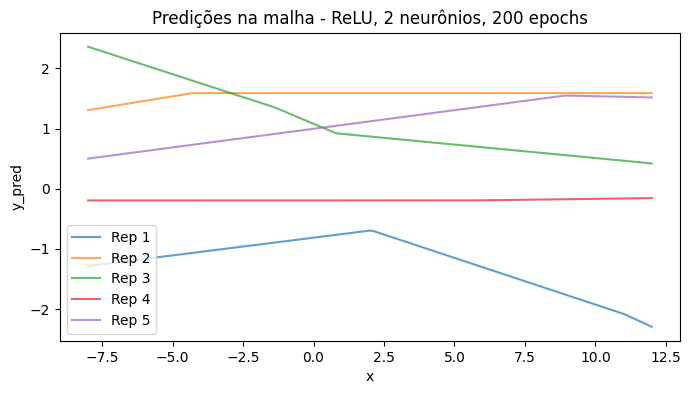

Ativação: ReLU, Neurônios: 2, Epochs: 1000
RMSE médio na validação: 1.1788 ± 0.2444


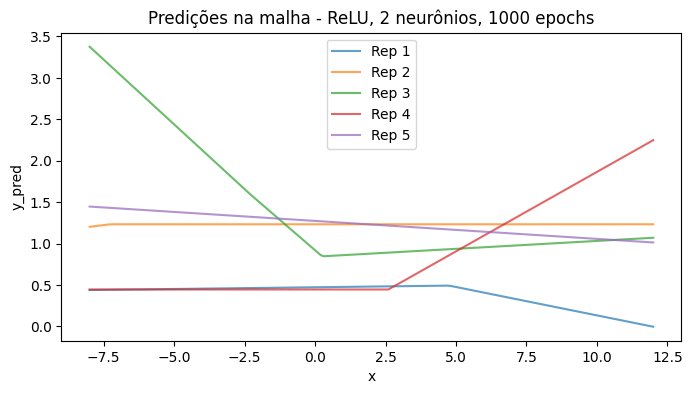

Ativação: ReLU, Neurônios: 4, Epochs: 200
RMSE médio na validação: 1.1201 ± 0.2509


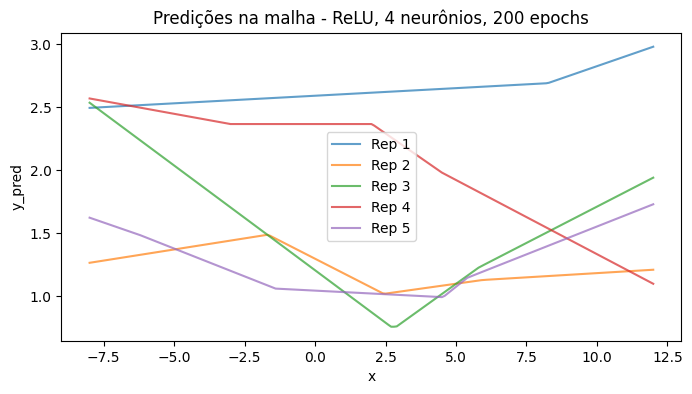

Ativação: ReLU, Neurônios: 4, Epochs: 1000
RMSE médio na validação: 0.7659 ± 0.1285


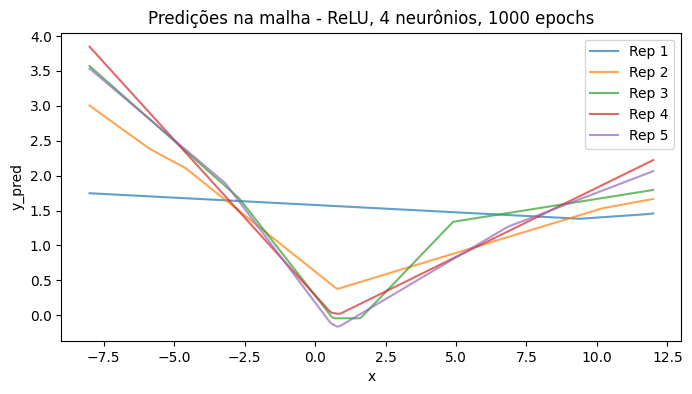

Ativação: ReLU, Neurônios: 8, Epochs: 200
RMSE médio na validação: 1.0911 ± 0.2683


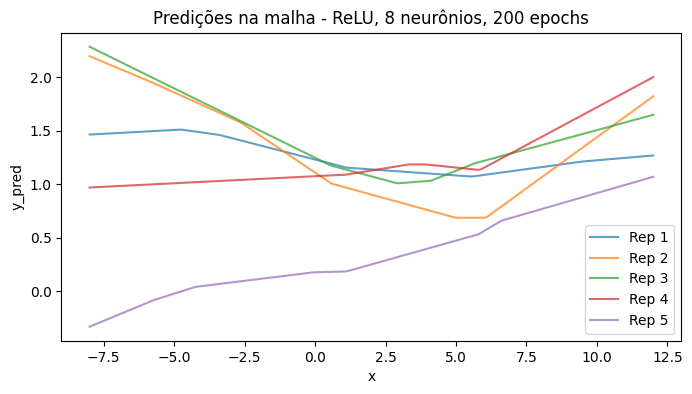

Ativação: ReLU, Neurônios: 8, Epochs: 1000
RMSE médio na validação: 0.7281 ± 0.0508


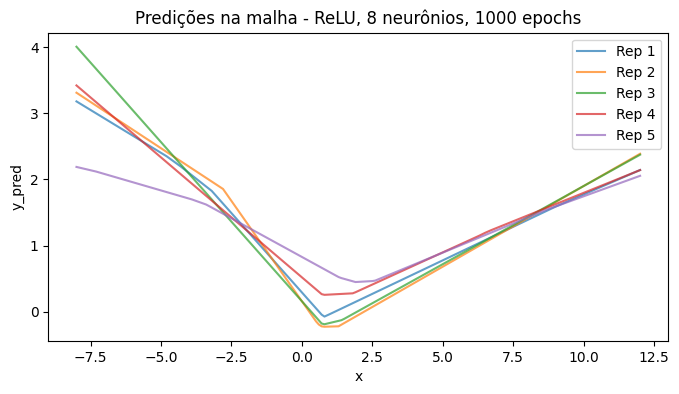

Ativação: ReLU, Neurônios: 16, Epochs: 200
RMSE médio na validação: 0.8059 ± 0.0436


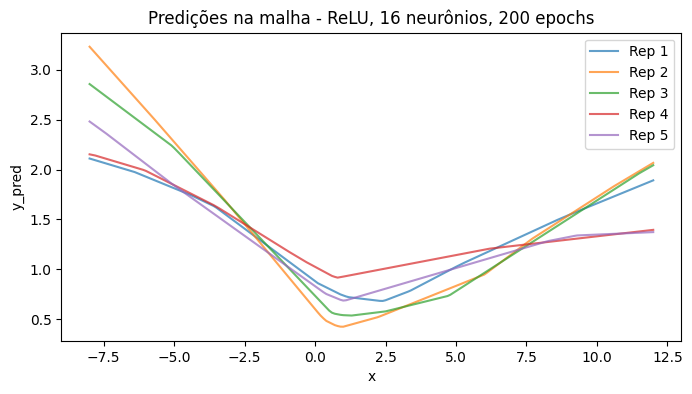

Ativação: ReLU, Neurônios: 16, Epochs: 1000
RMSE médio na validação: 0.6258 ± 0.0705


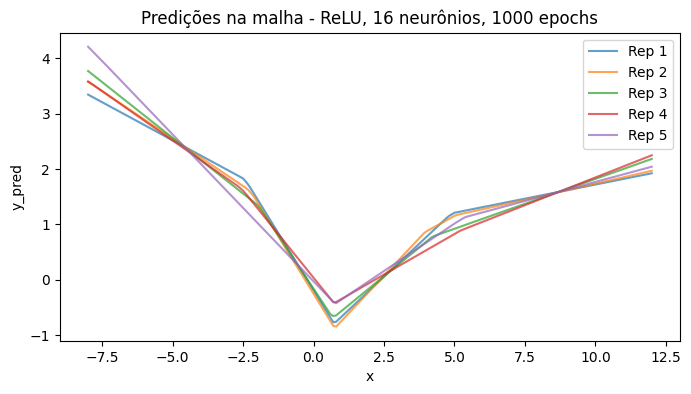

Ativação: ReLU, Neurônios: 32, Epochs: 200
RMSE médio na validação: 0.7432 ± 0.0185


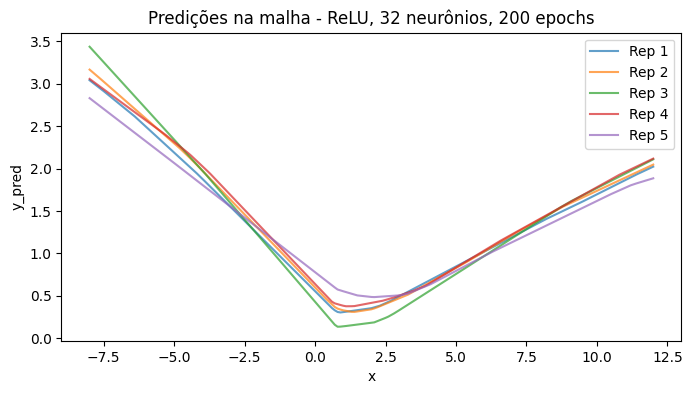

Ativação: ReLU, Neurônios: 32, Epochs: 1000
RMSE médio na validação: 0.4826 ± 0.0758


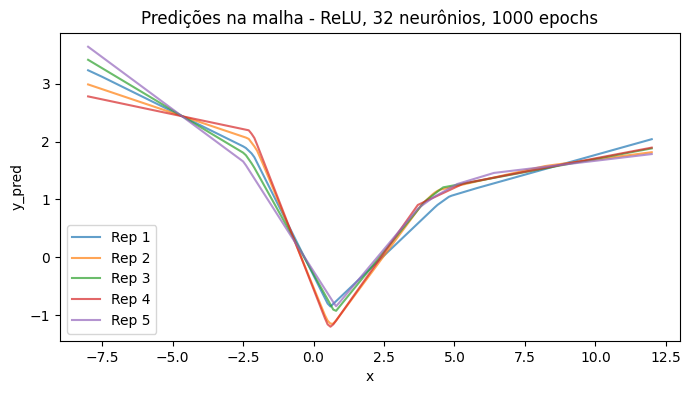

Ativação: tanh, Neurônios: 1, Epochs: 200
RMSE médio na validação: 1.6203 ± 0.4863


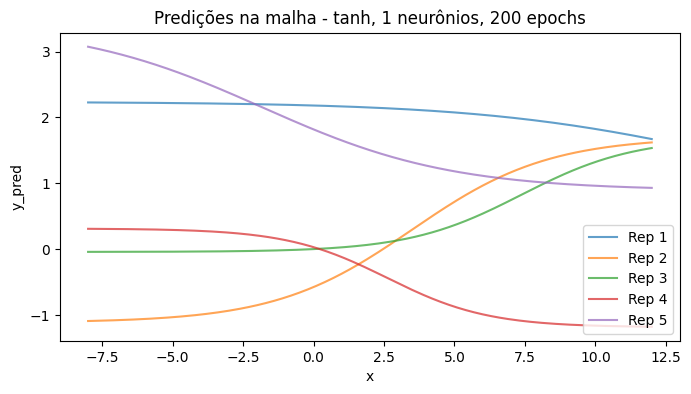

Ativação: tanh, Neurônios: 1, Epochs: 1000
RMSE médio na validação: 1.1211 ± 0.1041


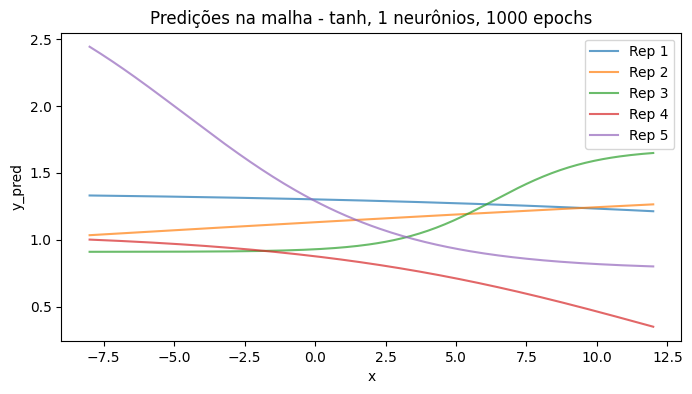

Ativação: tanh, Neurônios: 2, Epochs: 200
RMSE médio na validação: 1.5071 ± 0.4612


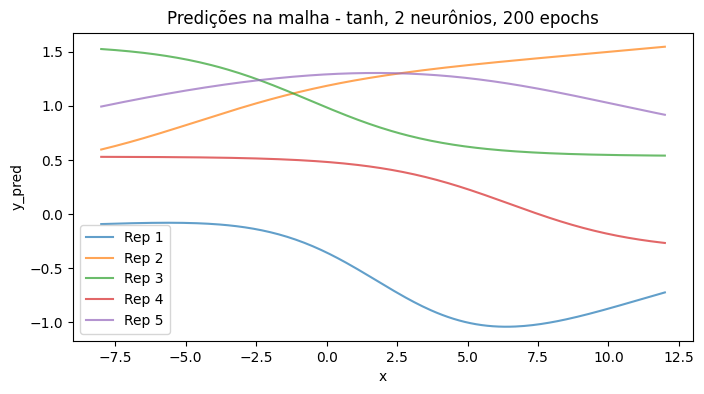

Ativação: tanh, Neurônios: 2, Epochs: 1000
RMSE médio na validação: 1.0654 ± 0.0713


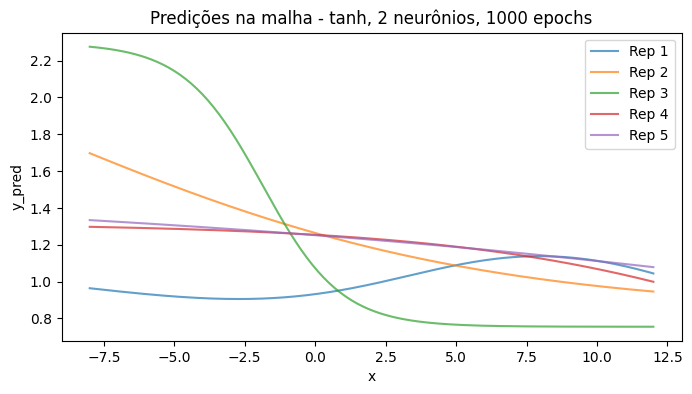

Ativação: tanh, Neurônios: 4, Epochs: 200
RMSE médio na validação: 1.1439 ± 0.0947


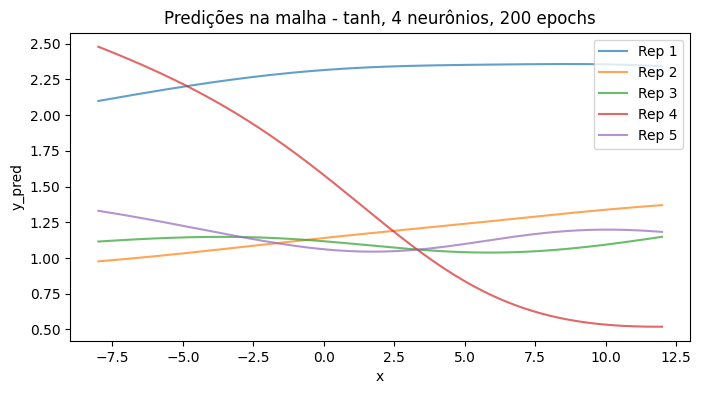

Ativação: tanh, Neurônios: 4, Epochs: 1000
RMSE médio na validação: 0.7324 ± 0.0675


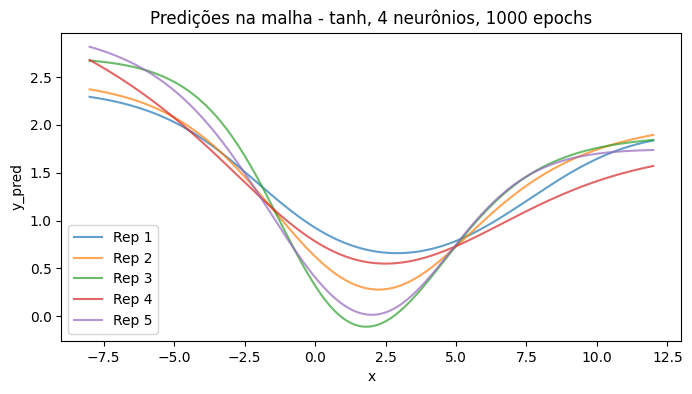

Ativação: tanh, Neurônios: 8, Epochs: 200
RMSE médio na validação: 1.1056 ± 0.0503


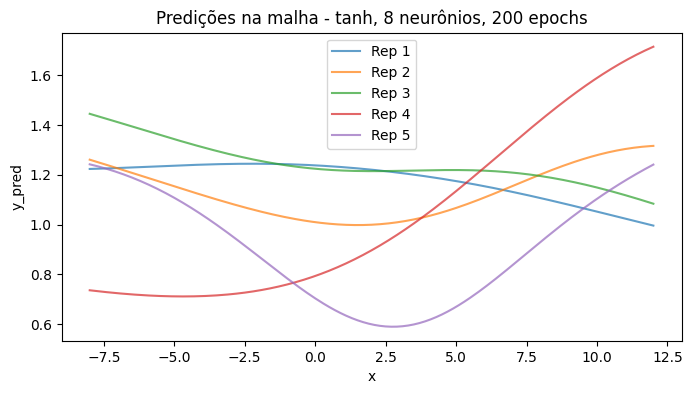

Ativação: tanh, Neurônios: 8, Epochs: 1000
RMSE médio na validação: 0.7180 ± 0.0505


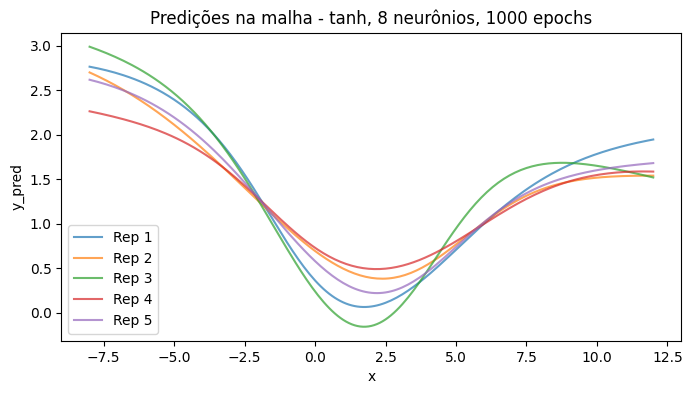

Ativação: tanh, Neurônios: 16, Epochs: 200
RMSE médio na validação: 1.0056 ± 0.0434


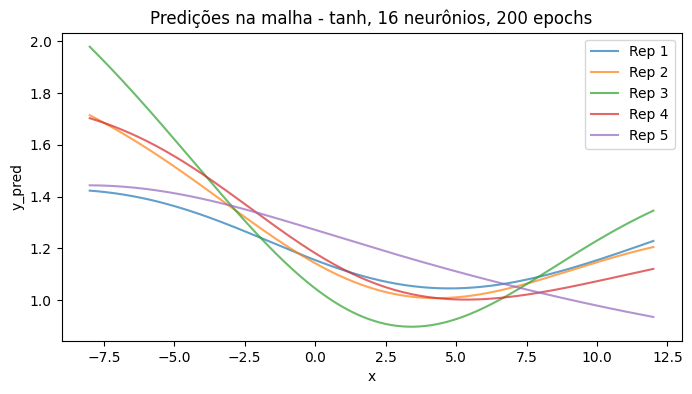

Ativação: tanh, Neurônios: 16, Epochs: 1000
RMSE médio na validação: 0.6935 ± 0.0371


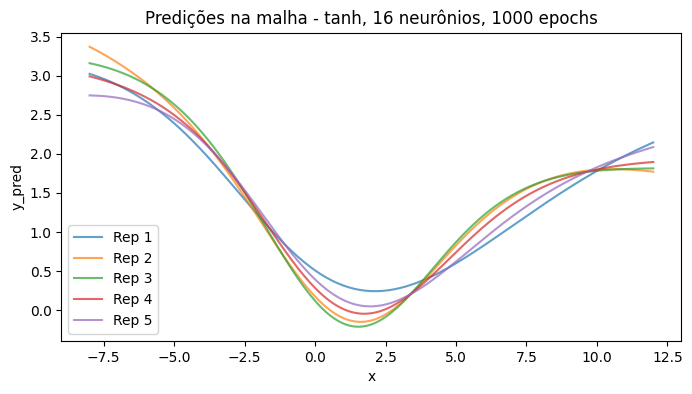

Ativação: tanh, Neurônios: 32, Epochs: 200
RMSE médio na validação: 0.9707 ± 0.0395


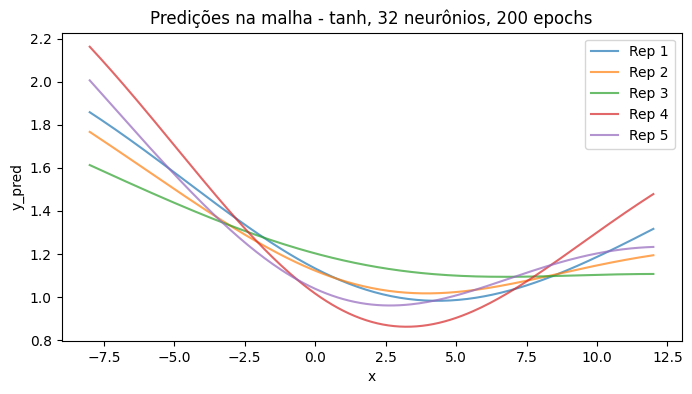

Ativação: tanh, Neurônios: 32, Epochs: 1000
RMSE médio na validação: 0.6531 ± 0.0243


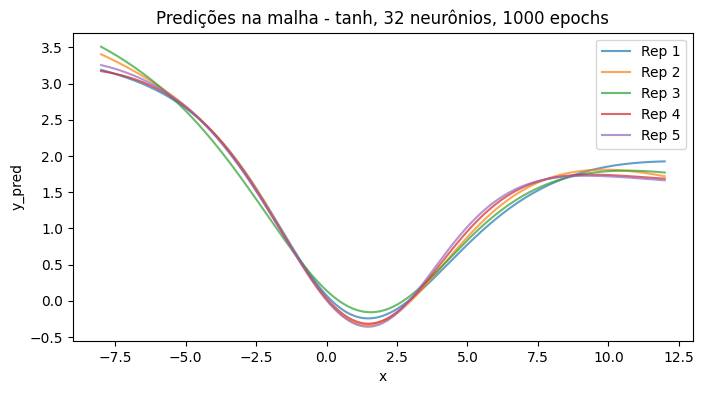

Ativação: sigmoid, Neurônios: 1, Epochs: 200
RMSE médio na validação: 1.2791 ± 0.2713


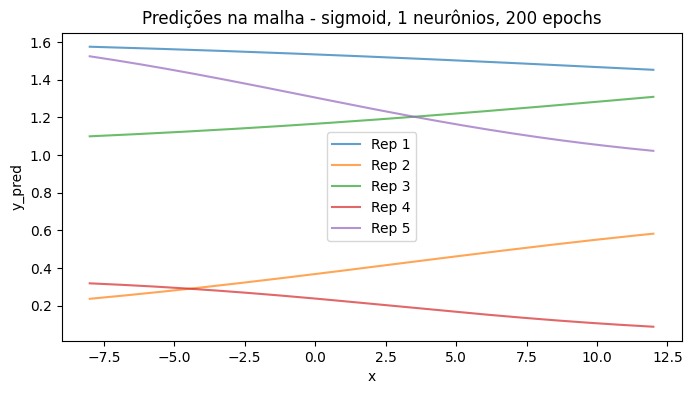

Ativação: sigmoid, Neurônios: 1, Epochs: 1000
RMSE médio na validação: 1.0812 ± 0.0437


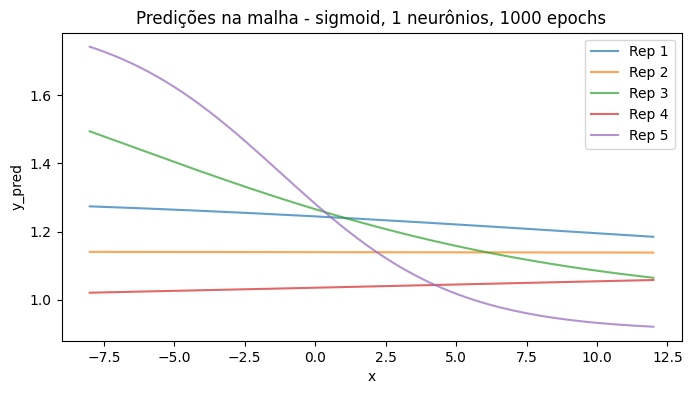

Ativação: sigmoid, Neurônios: 2, Epochs: 200
RMSE médio na validação: 1.2982 ± 0.2952


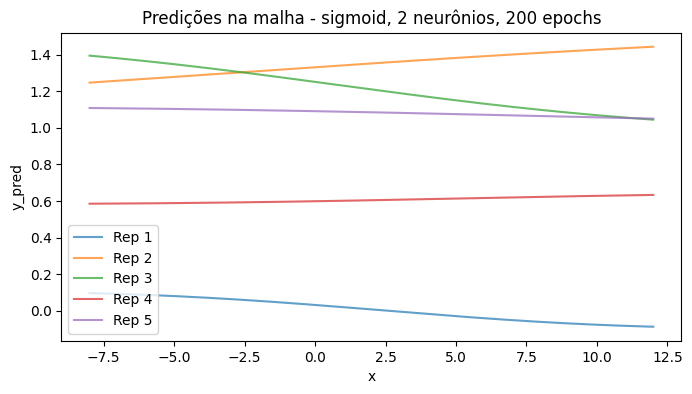

Ativação: sigmoid, Neurônios: 2, Epochs: 1000
RMSE médio na validação: 1.0688 ± 0.0428


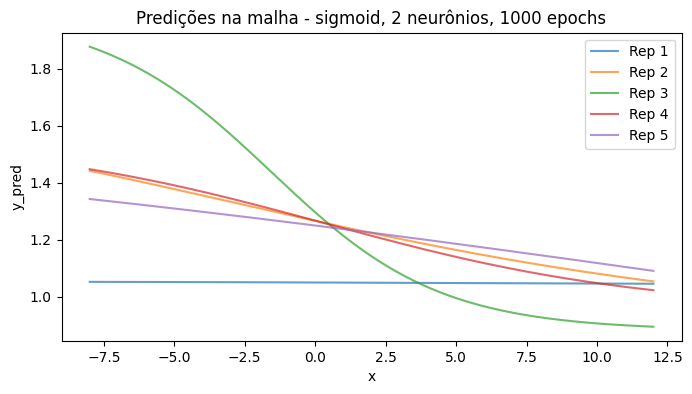

Ativação: sigmoid, Neurônios: 4, Epochs: 200
RMSE médio na validação: 1.0524 ± 0.0278


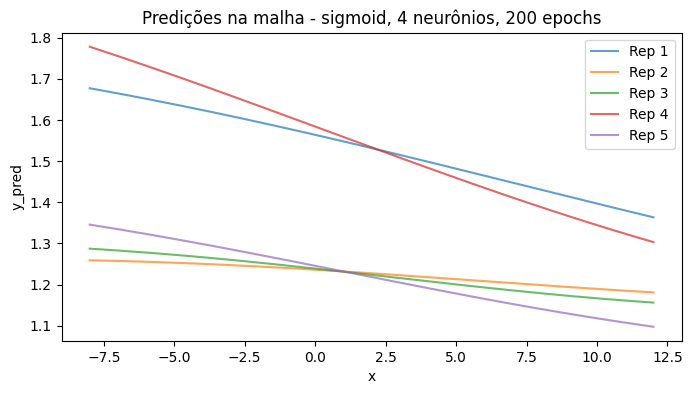

Ativação: sigmoid, Neurônios: 4, Epochs: 1000
RMSE médio na validação: 1.0221 ± 0.0527


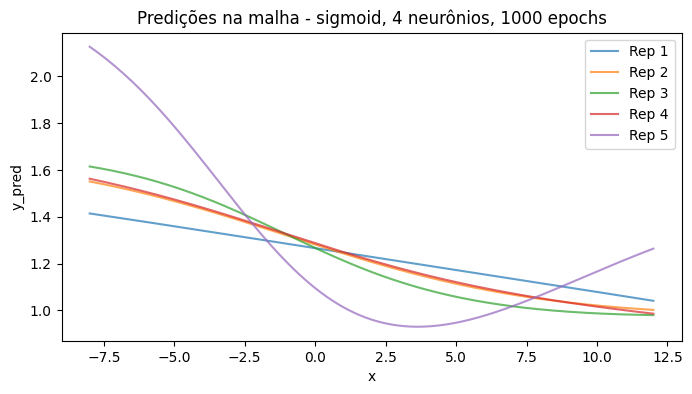

Ativação: sigmoid, Neurônios: 8, Epochs: 200
RMSE médio na validação: 1.0929 ± 0.0326


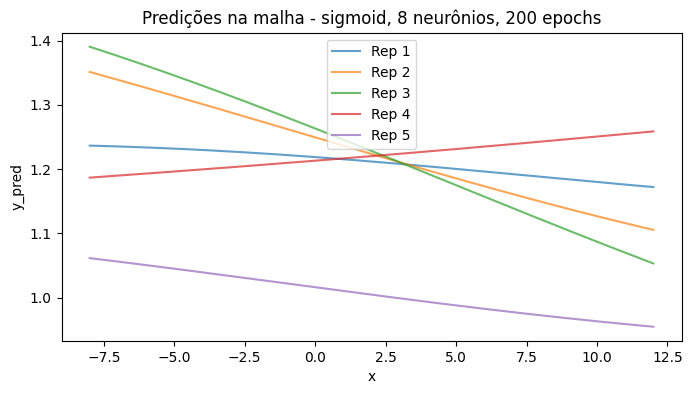

Ativação: sigmoid, Neurônios: 8, Epochs: 1000
RMSE médio na validação: 1.0381 ± 0.0240


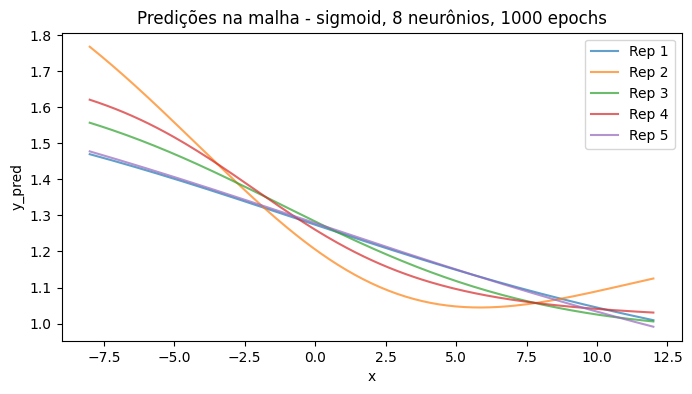

Ativação: sigmoid, Neurônios: 16, Epochs: 200
RMSE médio na validação: 1.0626 ± 0.0005


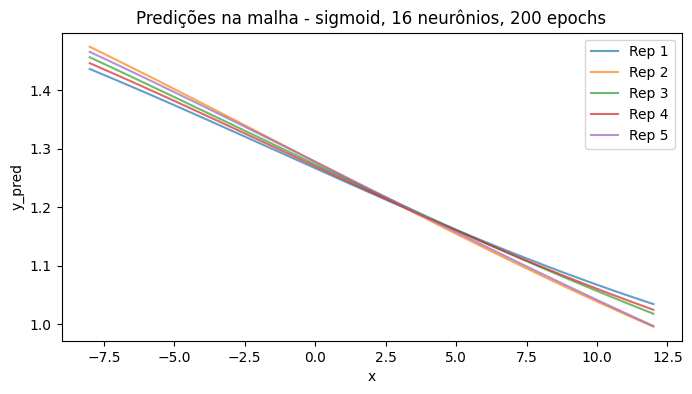

Ativação: sigmoid, Neurônios: 16, Epochs: 1000
RMSE médio na validação: 0.9393 ± 0.0826


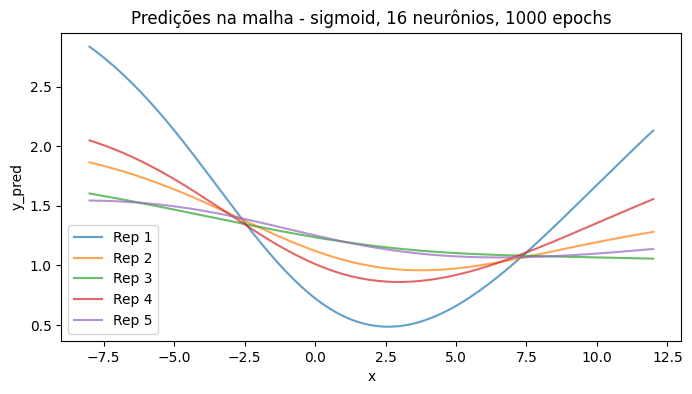

Ativação: sigmoid, Neurônios: 32, Epochs: 200
RMSE médio na validação: 1.0718 ± 0.0130


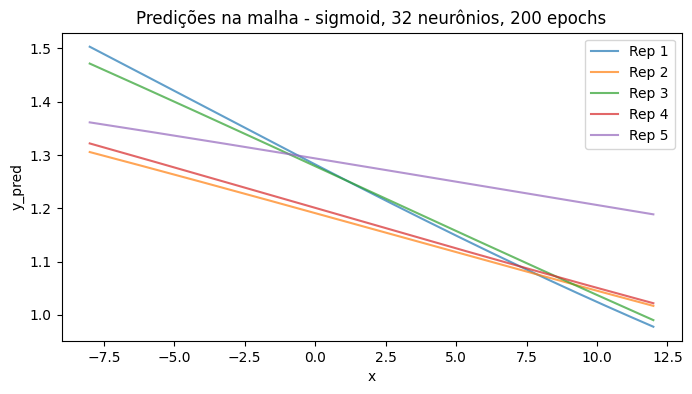

Ativação: sigmoid, Neurônios: 32, Epochs: 1000
RMSE médio na validação: 0.9747 ± 0.1278


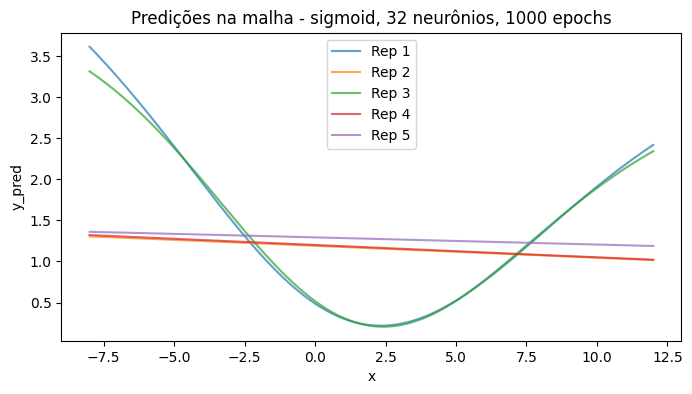

In [11]:
# =====================================================================================
# (3) TESTAR 5 REPETIÇÕES POR CONFIGURAÇÃO COM DIFERENTES EPOCHS E ANALISAR VARIABILIDADE
# =====================================================================================
# Para cada combinação (número de neurônios × função de ativação × epochs)
# vamos treinar 5 modelos com seeds diferentes e medir RMSE em validação.

import warnings

epochs_list = [200, 1000]
n_repeats = 5
results = []
hidden_sizes_list = hidden_candidates

for act_name, act_val in activations.items():
    for hs in hidden_sizes_list:
        for epochs in epochs_list:
            preds_on_grid = []
            rmses_val = []
            for rep in range(n_repeats):
                seed = 42 + rep
                model = MLPRegressor(
                    hidden_layer_sizes=(hs,),
                    activation=act_val,
                    solver='adam',
                    max_iter=epochs,
                    random_state=seed,
                    learning_rate_init=0.001,
                    tol=1e-6
                )
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    model.fit(Xs_train, ys_train)

                # Avaliação no conjunto de validação
                pred_val_s = model.predict(Xs_val)
                pred_val = sc_y.inverse_transform(pred_val_s.reshape(-1,1)).ravel()
                rmse_val = np.sqrt(mean_squared_error(y_val, pred_val))
                rmses_val.append(rmse_val)

                # Predição na malha xgrd
                pred_s = model.predict(xgrd_s)
                pred = sc_y.inverse_transform(pred_s.reshape(-1,1)).ravel()
                preds_on_grid.append(pred)

            results.append({
                'activation': act_name,
                'hidden': hs,
                'epochs': epochs,
                'preds_grid': np.array(preds_on_grid),
                'rmse_val_mean': np.mean(rmses_val),
                'rmse_val_std': np.std(rmses_val)
            })

for res in results:
    print(f"Ativação: {res['activation']}, Neurônios: {res['hidden']}, Epochs: {res['epochs']}")
    print(f"RMSE médio na validação: {res['rmse_val_mean']:.4f} ± {res['rmse_val_std']:.4f}")

    # Plotar predições na malha para as 5 repetições
    plt.figure(figsize=(8,4))
    for i in range(n_repeats):
        plt.plot(xgrd, res['preds_grid'][i], label=f'Rep {i+1}', alpha=0.7)
    plt.title(f"Predições na malha - {res['activation']}, {res['hidden']} neurônios, {res['epochs']} epochs")
    plt.xlabel('x')
    plt.ylabel('y_pred')
    plt.legend()
    plt.show()

In [12]:
# ================================================================
# (4) RELATÓRIO CURTO (PDF) COM RESULTADOS E DISCUSSÃO DOS ITENS 1-3
# ================================================================
# Gera um PDF com:
#  - capa
#  - gráficos com as curvas previstas e faixa de variação entre repetições
#  - destaque da melhor configuração
#  - texto resumindo os principais achados

# Identificar a melhor configuração (menor RMSE na validação)
best_cfg = min(results, key=lambda r: r['rmse_val_mean'])

with PdfPages("relatorio_final_mlp.pdf") as pdf:
    # Capa
    plt.figure(figsize=(8.27, 11.69))
    plt.axis('off')
    plt.text(0.5, 0.75, "Relatório Final - Experimentos MLP", ha='center', va='center', fontsize=18)
    plt.text(0.5, 0.65, "Desafio 01 - Redes Neurais Artificiais \nAluna: Cristiane Gea", ha='center', fontsize=14)
    plt.text(0.5, 0.5,
             "Itens avaliados:\n"
             "(1) Topologia mínima\n"
             "(2) Funções de ativação (ReLU, tanh, sigmoid)\n"
             "(3) Avaliação de 5 repetições por configuração\n"
             "(4) Relatório curto com discussão\n",
             ha='center', va='center', fontsize=10)
    pdf.savefig(); plt.close()

    # Páginas por ativação
    for act in activations.keys():
        cfgs = [r for r in results if r['activation']==act]
        # Adjust subplot grid size to accommodate all configurations (6 hidden sizes * 2 epochs = 12)
        fig, axes = plt.subplots(6, 2, figsize=(8.27, 11.69))
        fig.suptitle(f"Ativação: {act}", fontsize=14)
        axes = axes.flatten()
        for i, cfg in enumerate(sorted(cfgs, key=lambda x:(x['hidden'], x['epochs']))):
            ax = axes[i]
            preds = cfg['preds_grid']
            mean_pred = preds.mean(axis=0)
            ax.plot(xgrd.ravel(), ymean, label='ymean (alvo)', color='black')
            ax.plot(xgrd.ravel(), mean_pred, label=f'pred média (h={cfg["hidden"]})', color='blue')
            ax.fill_between(xgrd.ravel(), preds.min(axis=0), preds.max(axis=0), color='blue', alpha=0.2)
            title = f"h={cfg['hidden']}, ep={cfg['epochs']}\nRMSE={cfg['rmse_val_mean']:.3f}±{cfg['rmse_val_std']:.3f}"
            if cfg is best_cfg:
                title = "⭐ " + title
            ax.set_title(title, fontsize=8)
            ax.grid(True)
        for j in range(i+1, len(axes)):
            axes[j].axis('off')
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        pdf.savefig(fig); plt.close(fig)

    # Página de discussão
    plt.figure(figsize=(8.27, 11.69))
    plt.axis('off')
    text = (
        f"A melhor configuração encontrada foi ⭐ {best_cfg['activation']} com "
        f"{best_cfg['hidden']} neurônios e {best_cfg['epochs']} épocas, obtendo "
        f"RMSE médio de validação {best_cfg['rmse_val_mean']:.3f}±{best_cfg['rmse_val_std']:.3f}.\n\n"
        "Redes com poucos neurônios (2) não conseguiram capturar bem as oscilações da função. "
        "O aumento do número de neurônios e do número de épocas reduziu o erro e aumentou a estabilidade do treinamento. "
        "A ativação ReLU mostrou maior consistência entre repetições, enquanto sigmoid apresentou maior variabilidade."
    )
    plt.text(0.05, 0.95, text, va='top', fontsize=10, wrap=True)
    pdf.savefig(); plt.close()

print("✅ Relatório salvo como: relatorio_final_mlp.pdf")

/tmp/ipython-input-2889911409.py:49: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.97])
/tmp/ipython-input-2889911409.py:50: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  pdf.savefig(fig); plt.close(fig)


✅ Relatório salvo como: relatorio_final_mlp.pdf


/tmp/ipython-input-2889911409.py:64: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  pdf.savefig(); plt.close()
